In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

In [2]:
eicu_dataset_path = '/datasets/amelatur/eicu_7aakef5l/'
labels_labs = pd.read_csv( eicu_dataset_path + '0labels.txt')
patient_ids_labs = labels_labs['id']

vitals_col_names_all = ['temperature', 'spo2', 'heartrate', 'respiration', 'sbp', 'dbp', 'mbp']
vital_col_names_central = ['spo2', 'heartrate', 'respiration']
vital_col_names_no_bp = ['temperature', 'spo2', 'heartrate', 'respiration']
lab_col_names = ['paO2', 'fiO2', 'peep', 'lactate', 'presence']

eicu_diagnoses_path = "/datasets/amelatur/eicu_875pcqrq/"
labels_diags = pd.read_csv( eicu_diagnoses_path + '0labels.txt')
patient_ids_diags = labels_diags['id']

In [3]:
labels_labs

,id,weight,height,age,gender,ethnicity
0,2991274,66.5,149.0,65,Female,Caucasian
1,1445324,68.1,168.0,71,Male,Caucasian
2,2338866,106.6,172.7,57,Male,Caucasian
3,770980,87.6,182.8,83,Female,Caucasian
4,699332,120.0,182.0,34,Male,Hispanic
...,...,...,...,...,...,...
116951,1481078,46.3,152.0,52,Female,African American
116952,1144218,97.0,182.8,59,Male,Caucasian
116953,3018880,86.7,163.0,74,Male,Caucasian
116954,219111,58.9,165.1,48,Male,Hispanic


In [4]:
total_pts = 0
pts_all_vitals = 0
pts_central_vitals = 0
pts_vitals_no_bp = 0

for pat_id in patient_ids_labs:

    pt_file = pd.read_csv(eicu_dataset_path + str(pat_id) + '.csv', index_col=False)
    pt_file['time'] = pd.to_datetime(pt_file['time'])
    pt_file = pt_file.sort_values('time').set_index('time')

    vitals_all = pt_file[vitals_col_names_all]
    vitals_central = pt_file[vital_col_names_central]
    vitals_no_bp = pt_file[vital_col_names_no_bp]
    #labs = pt_file[lab_col_names]

    has_non_nan_all = vitals_all.notna().any().all()
    has_non_nan_central = vitals_central.notna().any().all()
    has_non_nan_no_bp = vitals_no_bp.notna().any().all()
    if has_non_nan_all:
        pts_all_vitals += 1
    if has_non_nan_central:
        pts_central_vitals += 1
    if has_non_nan_no_bp:
        pts_vitals_no_bp += 1
    total_pts += 1

print("total patients: ", total_pts)
print("patients with all vitals: ", pts_all_vitals)
print("patients with central vitals: ", pts_central_vitals)
print("patients with no bp vitals: ", pts_vitals_no_bp)

/tmp/ipykernel_339619/1064202481.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pt_file['time'] = pd.to_datetime(pt_file['time'])
/tmp/ipykernel_339619/1064202481.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pt_file['time'] = pd.to_datetime(pt_file['time'])
/tmp/ipykernel_339619/1064202481.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pt_file['time'] = pd.to_datetime(pt_file['time'])
/tmp/ipykernel_339619/1064202481.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consi

total patients:  116956
patients with all vitals:  8747
patients with central vitals:  108339
patients with no bp vitals:  14680


In [5]:
# save patient onset times for kidney, shock, and respiratory diagnoses


kidney_string_0 = "renal|kidney"

shock_string_0 = "shock"

respiratory_string_0 = "respiratory"

kidney_df = pd.DataFrame(columns=['patient_id', 'onset_time'])
shock_df = pd.DataFrame(columns=['patient_id', 'onset_time'])
respiratory_df = pd.DataFrame(columns=['patient_id', 'onset_time'])


for pat_id in tqdm(patient_ids_diags):

    pt_file = pd.read_csv(eicu_diagnoses_path + str(pat_id) + '.csv', index_col=False)

    if not pt_file.empty:
        pt_file['time'] = pd.to_datetime(pt_file['time'])
        pt_file = pt_file.sort_values('time').set_index('time')

        # find kidney onset time
        mask_kidney = pt_file['diag_string'].str.contains(kidney_string_0)
        matching_rows_kidney = pt_file[mask_kidney]
        earliest_match_index_kidney = matching_rows_kidney.index.min()
        new_row_kidney = {'patient_id': pat_id, 'onset_time': earliest_match_index_kidney}
        kidney_df = pd.concat([kidney_df, pd.DataFrame([new_row_kidney])])

        # find respi onset time
        mask_respi = pt_file['diag_string'].str.contains(respiratory_string_0)
        matching_rows_respi = pt_file[mask_respi]
        earliest_match_index_respi = matching_rows_respi.index.min()
        new_row_respi = {'patient_id': pat_id, 'onset_time': earliest_match_index_respi}
        respiratory_df = pd.concat([respiratory_df, pd.DataFrame([new_row_respi])])

        # find shock onset time
        mask_shock = pt_file['diag_string'].str.contains(shock_string_0)
        matching_rows_shock = pt_file[mask_shock]
        earliest_match_index_shock = matching_rows_shock.index.min()
        new_row_shock = {'patient_id': pat_id, 'onset_time': earliest_match_index_shock}
        shock_df = pd.concat([shock_df, pd.DataFrame([new_row_shock])])


kidney_df.to_csv(eicu_diagnoses_path + 'kidney_onset_times.csv', index=False)
respiratory_df.to_csv(eicu_diagnoses_path + 'respi_onset_times.csv', index=False)
shock_df.to_csv(eicu_diagnoses_path + 'shock_onset_times.csv', index=False)
                
   

  0%|          | 0/200859 [00:00<?, ?it/s]/tmp/ipykernel_339619/3466929811.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kidney_df = pd.concat([kidney_df, pd.DataFrame([new_row_kidney])])
/tmp/ipykernel_339619/3466929811.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  respiratory_df = pd.concat([respiratory_df, pd.DataFrame([new_row_respi])])
/tmp/ipykernel_339619/3466929811.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a

In [6]:
respiratory_onset_file = eicu_diagnoses_path + 'kidney' +'_onset_times.csv'
pd.read_csv(respiratory_onset_file)

,patient_id,onset_time
0,2991274,NaN
1,2394421,1900-01-01 20:02:00
2,1445324,NaN
3,2338866,NaN
4,770980,NaN
...,...,...
173104,3030177,1900-01-01 18:33:00
173105,660529,NaN
173106,1055485,NaN
173107,3139736,1900-01-01 16:00:00


In [15]:
import pandas as pd

vitals_file = pd.read_csv("/datasets/amelatur/eicu_7aakef5l/2338866.csv")
vitals_subset = vitals_file[['spo2', 'heartrate', 'respiration', 'time']]
#vitals_subset['time'] = pd.to_datetime(vitals_subset['time'])
vitals_subset = vitals_subset.set_index('time')
vitals_subset = vitals_subset.interpolate().bfill().ffill()
vitals_arr = vitals_subset.to_numpy()
vitals_arr.shape

(300, 3)

In [11]:
from joblib import Parallel, delayed
from tqdm import tqdm

def check_vitals(pat_id):

    pt_file = pd.read_csv(eicu_dataset_path + str(pat_id) + '.csv', index_col=False)
    pt_file['time'] = pd.to_datetime(pt_file['time'])
    pt_file = pt_file.sort_values('time').set_index('time')

    if not pt_file.empty:

        vitals_all = pt_file[vitals_col_names_all]
        vitals_central = pt_file[vital_col_names_central]
        vitals_no_bp = pt_file[vital_col_names_no_bp]

        has_non_nan_all = vitals_all.notna().any().all()
        has_non_nan_central = vitals_central.notna().any().all()
        has_non_nan_no_bp = vitals_no_bp.notna().any().all()

        if has_non_nan_all:
            vitals_status = 'all'
        elif has_non_nan_no_bp:
            vitals_status = 'no_bp'
        elif has_non_nan_central:
            vitals_status = 'central'
        else:
            vitals_status = None

        earliest_vital_time = pt_file.index.min() # gives us "start" time of patient input data

        sequence_length = pt_file.shape[0]

        return vitals_status, earliest_vital_time, sequence_length

    else:
        return None, None

def check_diagnoses(pat_id, earliest_vital_time, onset_csv):

    onset_time = onset_csv[onset_csv['patient_id'] == pat_id]['onset_time'].values
    if onset_time.size > 0:
        onset_time = onset_time[0]

        time_to_failure = None
        indices_to_failure = None

        if not pd.isnull(onset_time):

            onset_time_rounded = pd.to_datetime(onset_time).round('5min')
            time_to_failure = pd.to_timedelta(onset_time_rounded - earliest_vital_time)
            indices_to_failure = int(time_to_failure.total_seconds() / 300) # gives us 5 min indices

        else:
            time_to_failure = np.nan
            indices_to_failure = np.nan

        return time_to_failure, indices_to_failure
    else:
        return None, None

def get_failure(pat_id, disease):
    
    onset_csv = pd.read_csv(eicu_diagnoses_path + disease + '_onset_times.csv')
    vitals_status, earliest_vital_time, sequence_length = check_vitals(pat_id)

    if vitals_status is not None:
        time_to_failure, indices_to_failure = check_diagnoses(pat_id, earliest_vital_time, onset_csv)
        return {pat_id: [time_to_failure, indices_to_failure, vitals_status, sequence_length]}

    else:
        return {pat_id: [None, None, None, None]}

diseases = ['kidney', 'respi', 'shock']

def process_patient(pat_id, disease):

    result = get_failure(pat_id, disease)

    df = pd.DataFrame(result).T

    df.to_csv(f'{disease}.csv', mode='a', header=False)

# Run process_patient in parallel for all patient IDs
Parallel(n_jobs=-1)(delayed(process_patient)(patient_id, 'kidney') for patient_id in tqdm(patient_ids_labs))


  0%|          | 144/116956 [00:00<09:40, 201.20it/s]/tmp/ipykernel_774449/1641537756.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/tmp/ipykernel_774449/1641537756.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  3%|▎         | 3024/116956 [00:11<06:59, 271.67it/s]/tmp/ipykernel_774449/1641537756.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/tmp/ipykernel_774449/1641537756.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [12]:
Parallel(n_jobs=-1)(delayed(process_patient)(patient_id, 'respi') for patient_id in tqdm(patient_ids_labs))
Parallel(n_jobs=-1)(delayed(process_patient)(patient_id, 'shock') for patient_id in tqdm(patient_ids_labs))

  3%|▎         | 3744/116956 [00:14<07:33, 249.50it/s]/tmp/ipykernel_774449/1641537756.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/tmp/ipykernel_774449/1641537756.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  5%|▍         | 5792/116956 [00:22<07:16, 254.50it/s]/tmp/ipykernel_774449/1641537756.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/tmp/ipykernel_774449/1641537756.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [13]:
df = pd.read_csv('shock.csv', header=None)
df.columns = ['patient_ID', 'time_to_onset', 'indices_to_onset', 'vitals_available', 'stay_length']  # 
df.to_csv(f'shock_labels.csv', index=False)

df = pd.read_csv('kidney.csv', header=None)
df.columns = ['patient_ID', 'time_to_onset', 'indices_to_onset', 'vitals_available', 'stay_length']  # 
df.to_csv(f'kidney_labels.csv', index=False)

df = pd.read_csv('respi.csv', header=None)
df.columns = ['patient_ID', 'time_to_onset', 'indices_to_onset', 'vitals_available', 'stay_length']  # 
df.to_csv(f'respi_labels.csv', index=False)

Respiratory Failure
total patients:  116956
positive patients all vitals:  279
positive patients central vitals:  3937
positive patients no bp vitals:  346
negative patients all vitals:  2997
negative patients central vitals:  49581
negative patients no bp vitals:  1914


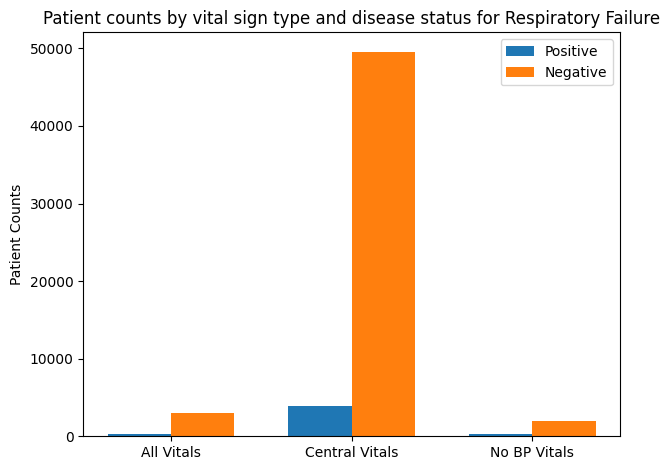

Kidney Failure
total patients:  116956
positive patients all vitals:  337
positive patients central vitals:  5932
positive patients no bp vitals:  447
negative patients all vitals:  2975
negative patients central vitals:  47188
negative patients no bp vitals:  1891


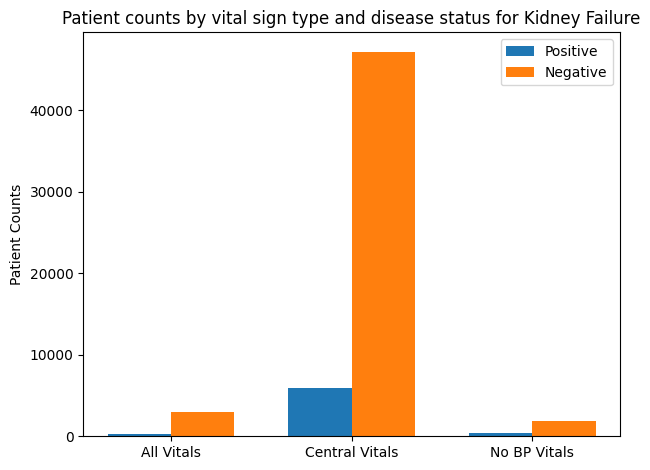

Shock
total patients:  116956
positive patients all vitals:  284
positive patients central vitals:  3506
positive patients no bp vitals:  287
negative patients all vitals:  3016
negative patients central vitals:  50806
negative patients no bp vitals:  2025


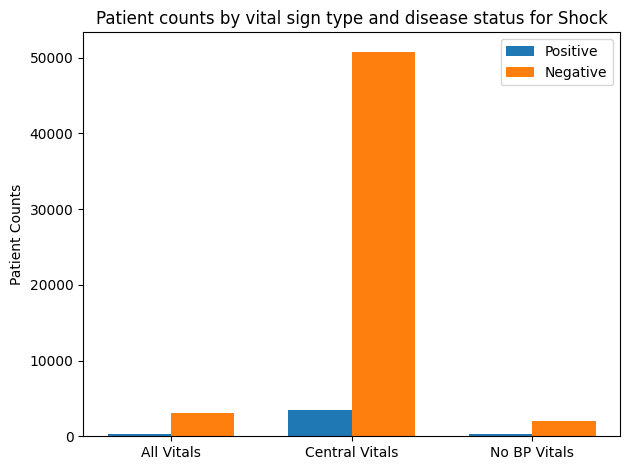

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def get_cohort_sizes(disease_label_file, disease_name):
    df = pd.read_csv(disease_label_file)
    total_pts = len(df.index)
    pts_central_vitals = (df[df['vitals_available'] == 'central'])['patient_ID']
    pts_all_vitals = (df[df['vitals_available'] == 'all'])['patient_ID']
    pts_no_bp = (df[df['vitals_available'] == 'no_bp'])['patient_ID']

    pts_stay_length_lower = (df[df['stay_length'] >= 144])['patient_ID'] # stay length >= 12 hours
    pts_stay_length_upper = (df[df['stay_length'] <= 3 * 24 * (60//5)])['patient_ID'] # stay length <= 7 days

    pts_onset_time_pos = (df[df['indices_to_onset'] >= (2*60)/5])['patient_ID'] # onset time >= 4 hours
    #pts_onset_time_pos = (df[df['indices_to_onset'].notna()])['patient_ID'] # onset time >= 24 hours

    pts_neg = (df[df['time_to_onset'].isna()])['patient_ID']

    pos_pts_intersect = np.intersect1d(pts_onset_time_pos, np.intersect1d(pts_stay_length_lower, pts_stay_length_upper))

    neg_pts_intersect = np.intersect1d(pts_neg, np.intersect1d(pts_stay_length_lower, pts_stay_length_upper))

    pos_pts_all_vitals = pd.Series(np.intersect1d(pos_pts_intersect, pts_all_vitals))
    pos_pts_central_vitals = pd.Series(np.intersect1d(pos_pts_intersect, pts_central_vitals))
    pos_pts_no_bp = pd.Series(np.intersect1d(pos_pts_intersect, pts_no_bp))

    neg_pts_all_vitals = pd.Series(np.intersect1d(neg_pts_intersect, pts_all_vitals))
    neg_pts_central_vitals = pd.Series(np.intersect1d(neg_pts_intersect, pts_central_vitals))
    neg_pts_no_bp = pd.Series(np.intersect1d(neg_pts_intersect, pts_no_bp))

    print("total patients: ", total_pts)
    print("positive patients all vitals: ", len(pos_pts_all_vitals))
    print("positive patients central vitals: ", len(pos_pts_central_vitals))
    print("positive patients no bp vitals: ", len(pos_pts_no_bp))
    print("negative patients all vitals: ", len(neg_pts_all_vitals))
    print("negative patients central vitals: ", len(neg_pts_central_vitals))
    print("negative patients no bp vitals: ", len(neg_pts_no_bp))

    # Create a bar chart
    labels = ['All Vitals', 'Central Vitals', 'No BP Vitals']
    pos_counts = [len(pos_pts_all_vitals), len(pos_pts_central_vitals), len(pos_pts_no_bp)]
    neg_counts = [len(neg_pts_all_vitals), len(neg_pts_central_vitals), len(neg_pts_no_bp)]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, pos_counts, width, label='Positive')
    rects2 = ax.bar(x + width/2, neg_counts, width, label='Negative')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Patient Counts')
    ax.set_title(f'Patient counts by vital sign type and disease status for {disease_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()


print("Respiratory Failure")
get_cohort_sizes('respi_labels.csv', "Respiratory Failure")
print("Kidney Failure")
get_cohort_sizes('kidney_labels.csv', "Kidney Failure")
print("Shock")
get_cohort_sizes('shock_labels.csv', "Shock")






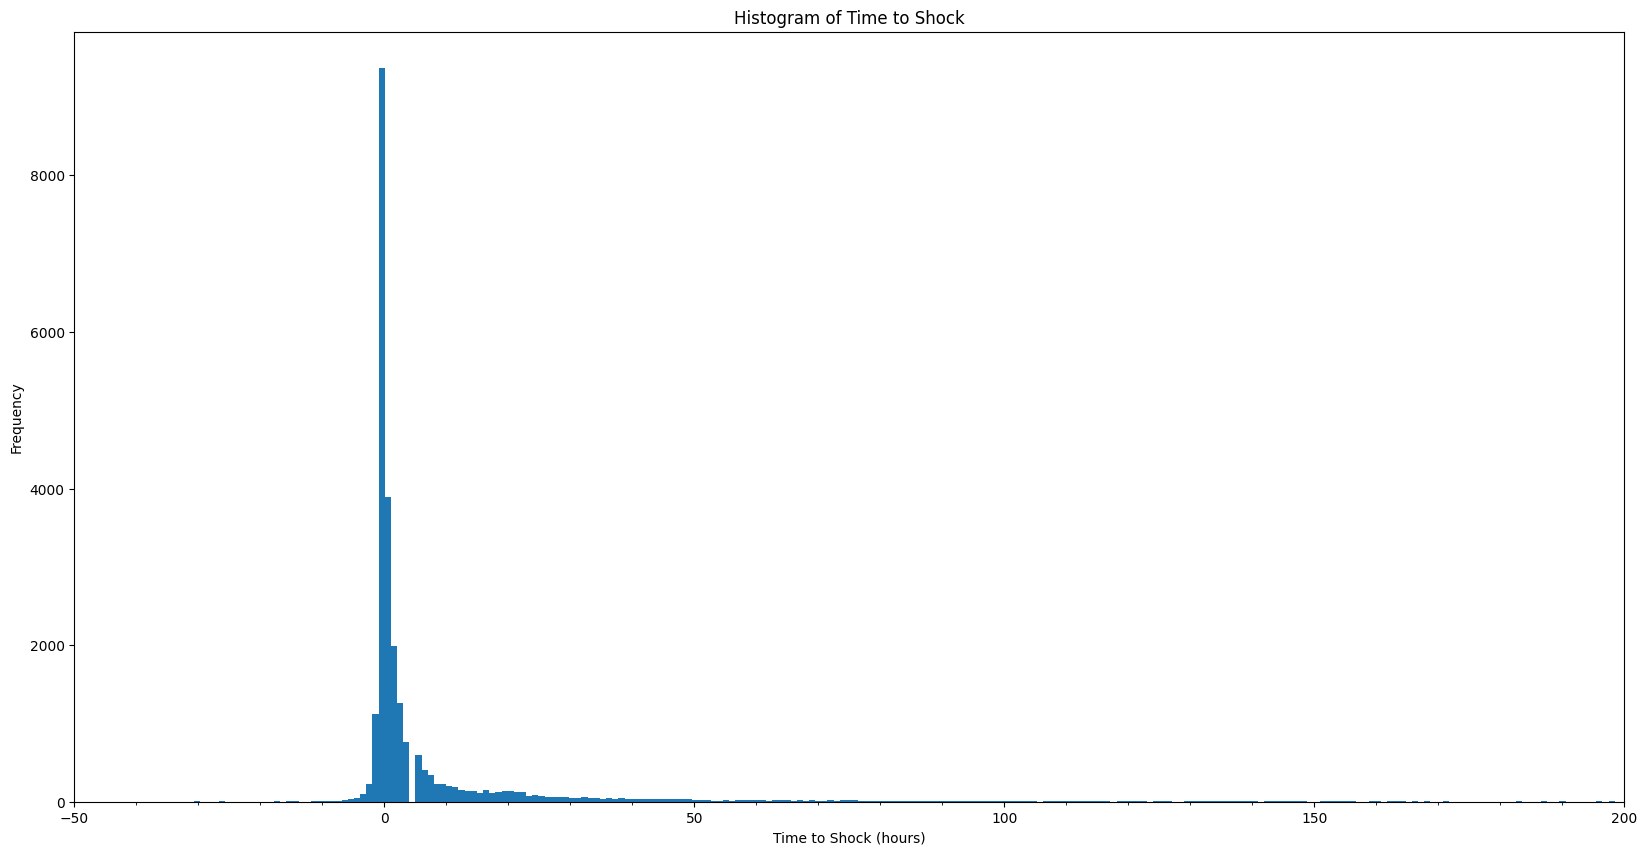

In [8]:
import matplotlib.ticker as ticker


# convert timedelta values to seconds and remove NaN values
time_to_shock_failure_seconds = [x.total_seconds()//3600 for x in time_to_shock_failure_lst if pd.notnull(x)]

# plot histogram
plt.figure(figsize=(20, 10))
plt.hist(time_to_shock_failure_seconds, bins=1000)
plt.xlabel('Time to Shock (hours)')
plt.ylabel('Frequency')
plt.xlim(-50, 200)
plt.title('Histogram of Time to Shock')

# add minor ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.show()

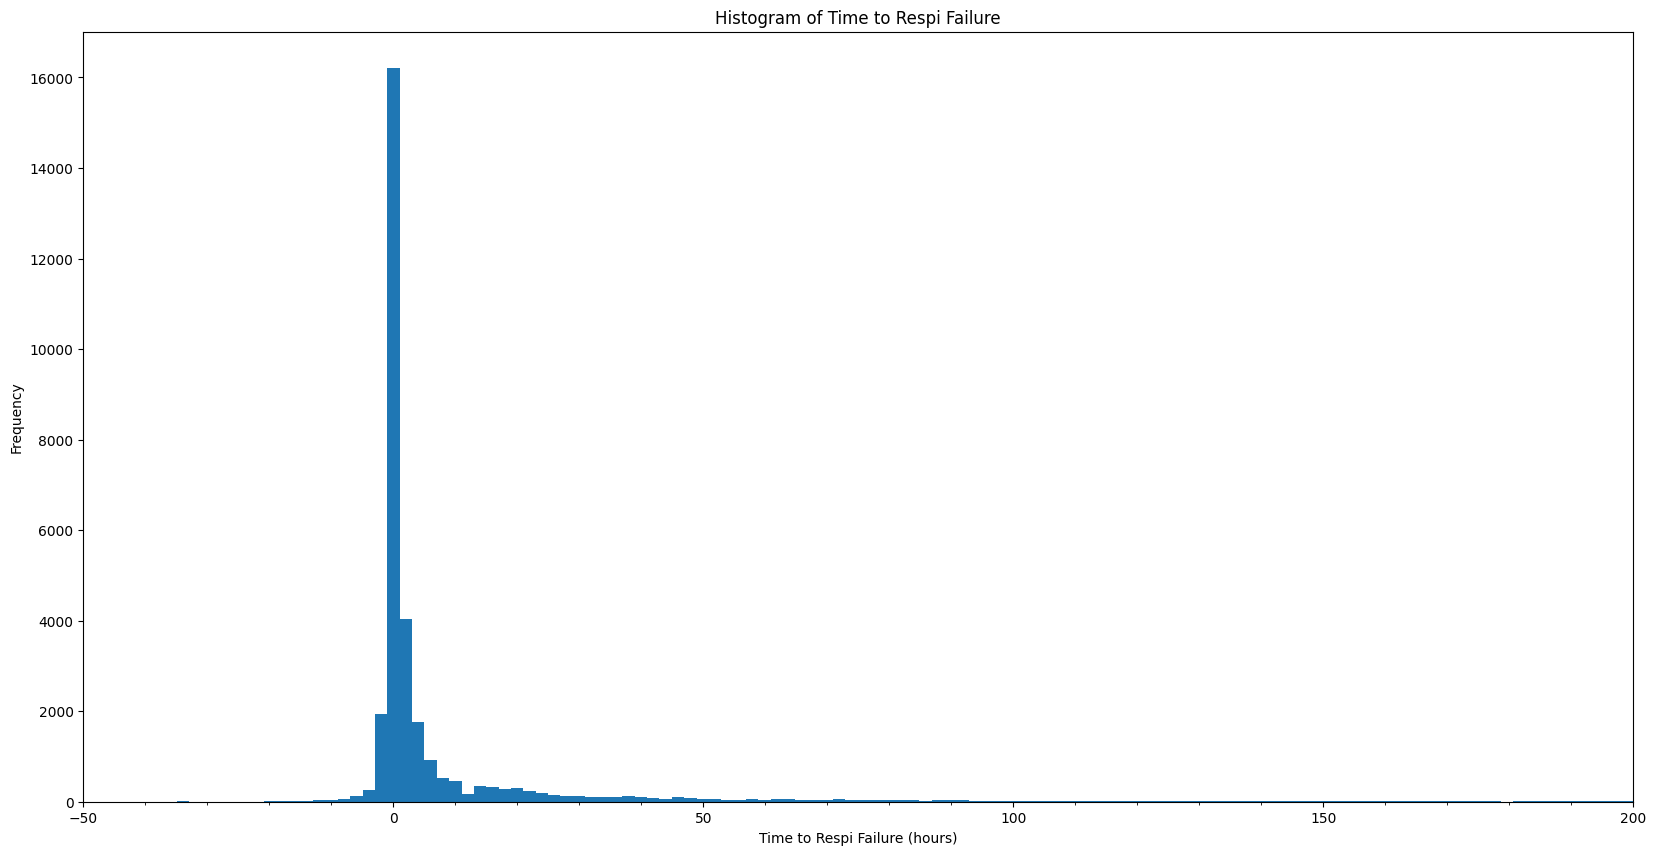

In [9]:
import matplotlib.ticker as ticker


# convert timedelta values to seconds and remove NaN values
time_to_respi_failure_seconds = [x.total_seconds()//3600 for x in time_to_respiratory_failure_lst if pd.notnull(x)]

# plot histogram
plt.figure(figsize=(20, 10))
plt.hist(time_to_respi_failure_seconds, bins=1000)
plt.xlabel('Time to Respi Failure (hours)')
plt.ylabel('Frequency')
plt.xlim(-50, 200)
plt.title('Histogram of Time to Respi Failure')

# add minor ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.show()

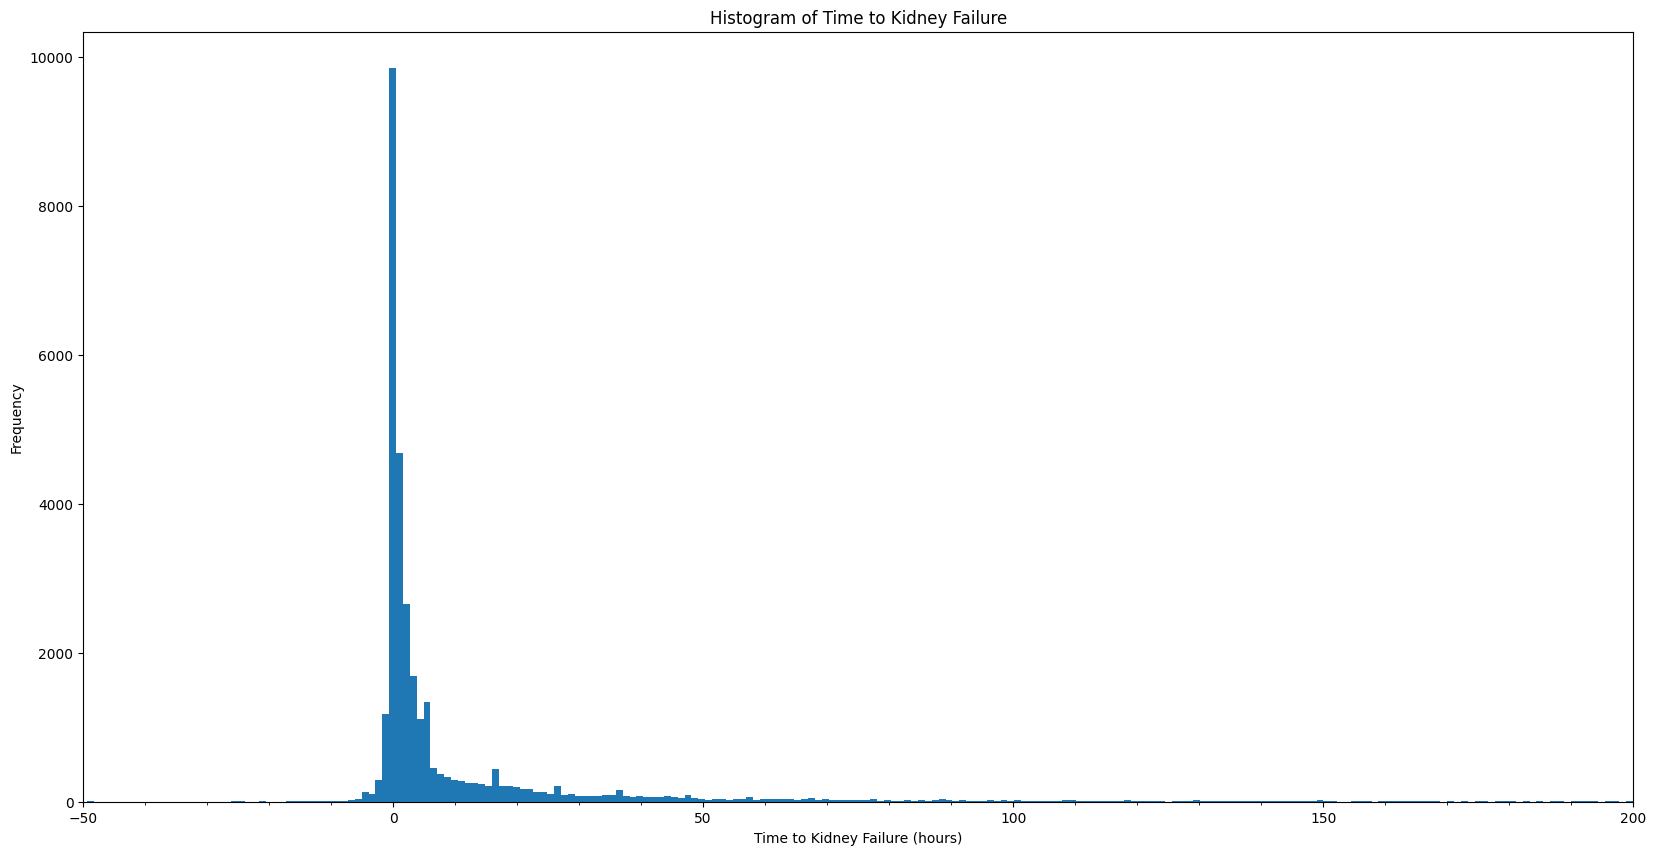

In [10]:
import matplotlib.ticker as ticker


# convert timedelta values to seconds and remove NaN values
time_to_kidney_failure_seconds = [x.total_seconds()//3600 for x in time_to_kidney_failure_lst if pd.notnull(x)]

# plot histogram
plt.figure(figsize=(20, 10))
plt.hist(time_to_kidney_failure_seconds, bins=1000)
plt.xlabel('Time to Kidney Failure (hours)')
plt.ylabel('Frequency')
plt.xlim(-50, 200)
plt.title('Histogram of Time to Kidney Failure')

# add minor ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())


[[345 117]
 [ 55  99]]
              precision    recall  f1-score   support

           0       0.86      0.75      0.80       462
           1       0.46      0.64      0.54       154

    accuracy                           0.72       616
   macro avg       0.66      0.69      0.67       616
weighted avg       0.76      0.72      0.73       616

AUPRC: 0.49395189505658643
AUROC: 0.7526142688480351


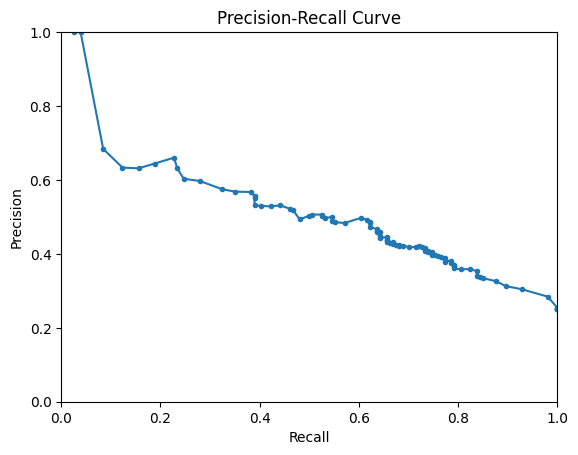

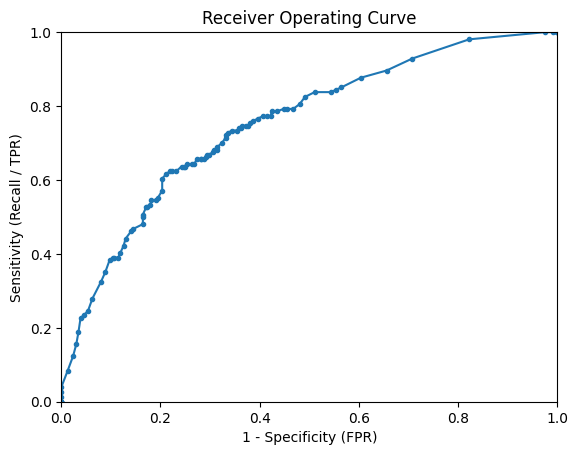

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

predictions = np.load('/datasets/amelatur/whole_sequences/eicu/eicu/kidney/raw_preds_transformer_lookahead_test_train_mask_6_24.npy')
targets = np.load('/datasets/amelatur/whole_sequences/eicu/eicu/kidney/targets_test_6_24.npy')

precisions, recalls, specificities, fpr_ls = eval(predictions, targets, 6)



In [2]:
def mark_sequences(binary_array, k):
    count = 0
    start_index = None
    for i in range(len(binary_array)):
        if binary_array[i] == 1:
            if count == 0:
                start_index = i
            count += 1
            if count > k:
                binary_array[start_index+1:i+1] = 0
        else:
            if count <= k and start_index is not None:
                binary_array[start_index:i] = 0
            count = 0
            start_index = None
    # Handle the last sequence of 1s
    if count <= k and start_index is not None:
        binary_array[start_index:i+1] = 0
    return binary_array

In [4]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import auc


def eval(predictions, targets, k=6):
    thresholds = np.arange(0, 1, 0.01).tolist()

    precisions = []
    recalls = []
    specificities = []
    fpr_ls = []


    for threshold in thresholds:
        out = []
        ground_truth = []
        for i in range(predictions.shape[0]):

            target = targets[i]
            predicted = predictions[i]

            predicted_thresholded = (predicted > threshold).astype(int)

            last_index = np.where(target == 100000.0)[0]
            if last_index.size != 0:
                last_index = last_index[0]
                target = target[:last_index]
            else:
                last_index = None

            assert np.sum(target == 100000.0) == 0

            predicted_thresholded = mark_sequences(predicted_thresholded, k)

            #predicted_thresholded = predicted_thresholded[36:] # mute first two hours of predictions
            
            if np.sum(target == 1.0) > 0: # positive patient

                if last_index != None:
                    predicted_thresholded = predicted_thresholded[:last_index]

                ground_truth.append(1)
                if np.sum(predicted_thresholded) > 0:
                    out.append(1)
                else:
                    out.append(0)
            elif np.sum(target == 1.0) == 0: # negative patient
                ground_truth.append(0)
                if last_index != None:
                    predicted_thresholded = predicted_thresholded[:last_index]

                if np.sum(predicted_thresholded) > 0:
                    out.append(1)
                else:
                    out.append(0)

        
        if threshold == 0.5:
            print(confusion_matrix(ground_truth, out))
            print(classification_report(ground_truth, out))

        tn, fp, fn, tp = confusion_matrix(ground_truth, out).ravel()
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        specificity = tn / (tn + fp)

        precisions.append(precision)
        recalls.append(recall)
        specificities.append(specificity)
        fpr_ls.append(1 - specificity)

    # print(confusion_matrix(ground_truth, out))

    # print(classification_report(ground_truth, out))

    # model.evaluate(test_data_loader)

    # eval_auprc_auroc()
        
    precisions_rev = precisions[::-1]
    recalls_rev = recalls[::-1]

    # Use a list comprehension to filter out pairs where either value is NaN
    filtered_pairs = [(x, y) for x, y in zip(precisions_rev, recalls_rev) if not (np.isnan(x) or np.isnan(y))]

    # Split the filtered pairs back into two lists
    precisions_rev, recalls_rev = zip(*filtered_pairs)


    precisions_rev = precisions_rev[1:]
    recalls_rev = recalls_rev[1:]

    auprc = auc(recalls_rev, precisions_rev)
    print("AUPRC: " + str(auprc))

    plt.plot(recalls_rev, precisions_rev, marker='.')
    plt.xlabel('Recall')
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    #plt.show()

    fpr_rev = fpr_ls[::-1]
    recalls_rev = recalls[::-1]
    # fpr_rev = fpr_rev[4:]
    # recalls_rev = recalls_rev[4:]

    auroc = auc(fpr_rev, recalls_rev)
    print("AUROC: " + str(auroc))

    plt.figure()  # Create a new figure
    plt.plot(fpr_rev, recalls_rev, marker='.')
    plt.ylabel('Sensitivity (Recall / TPR)')
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.xlabel('1 - Specificity (FPR)')
    plt.title('Receiver Operating Curve')
    #plt.show()

    return precisions, recalls, specificities, fpr_ls

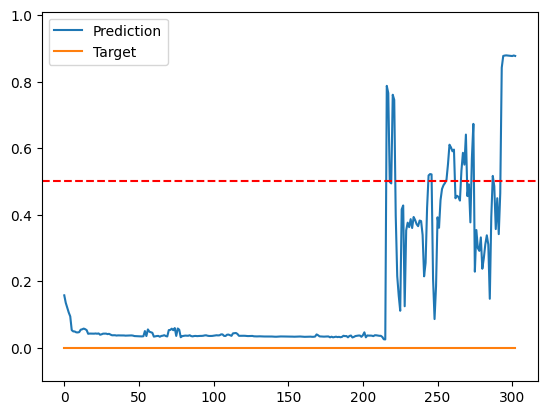

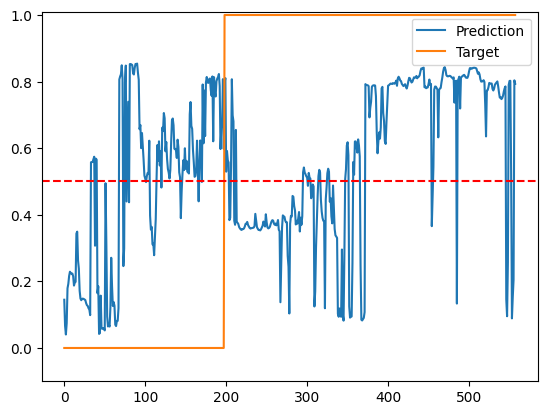

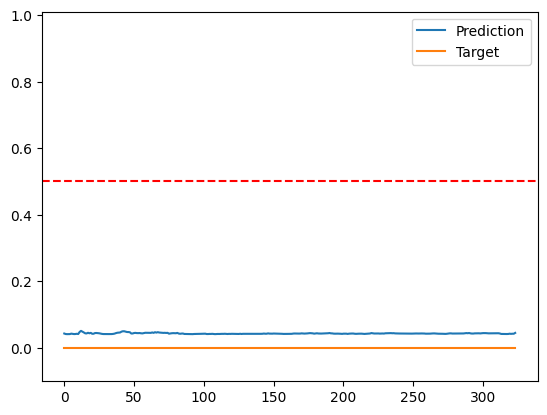

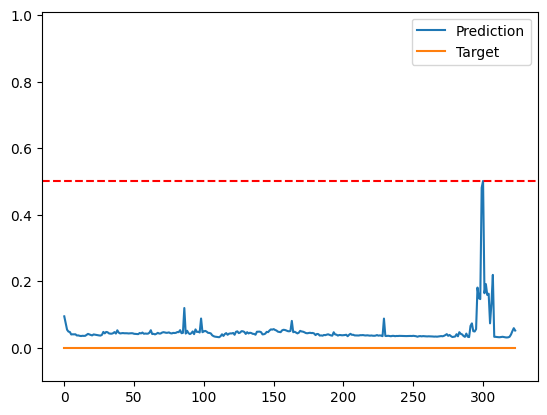

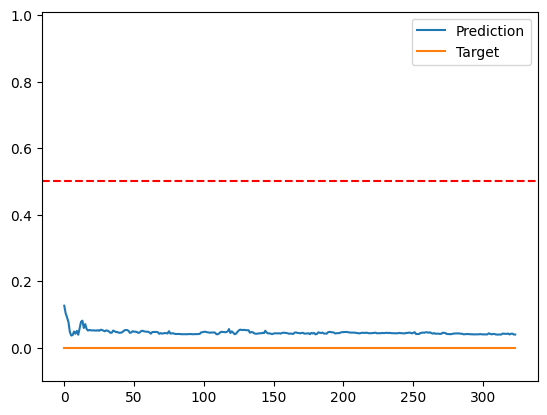

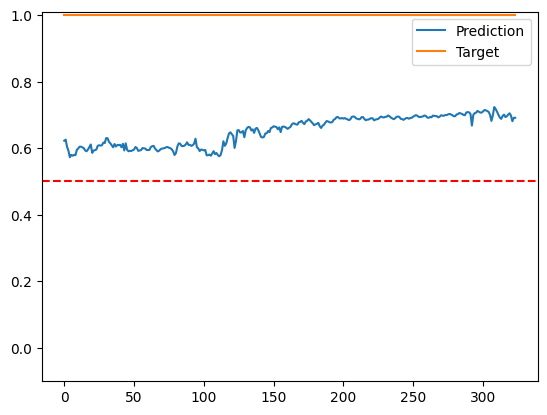

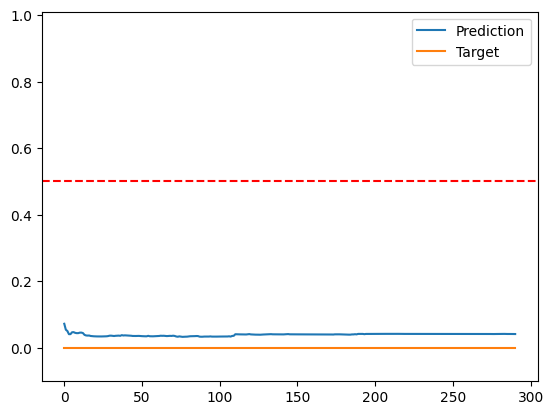

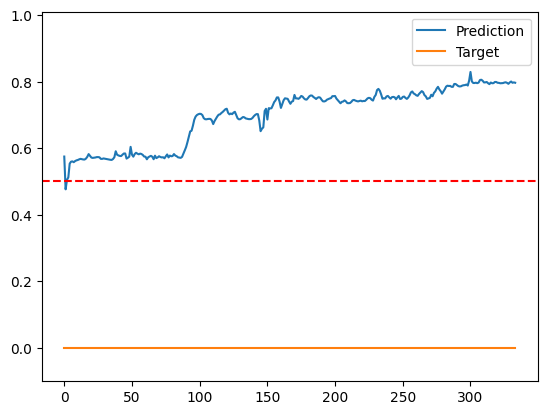

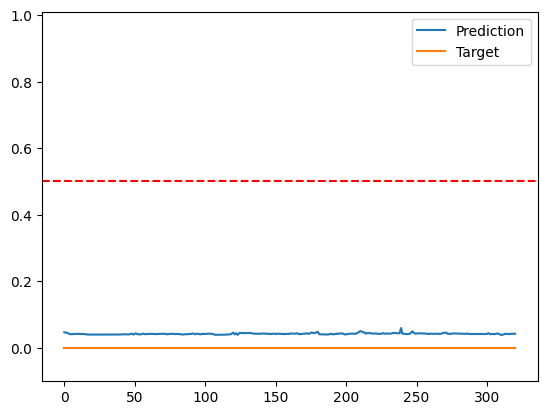

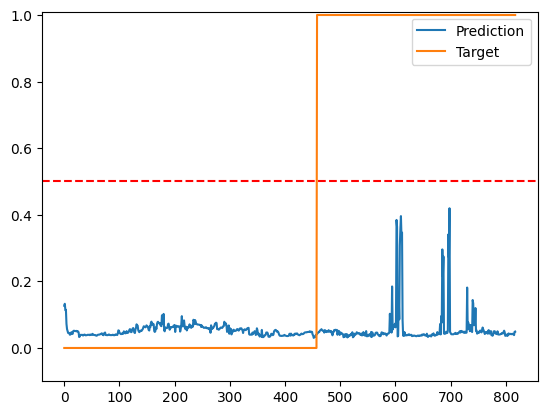

In [6]:
for i in range(50, 60):

    out = predictions[i]
    target = targets[i]

    last_index = np.where(target == 100000.0)[0]
    if last_index.size != 0:
        last_index = last_index[0]
        target = target[:last_index]
        out = out[:last_index]
    else:
        last_index = None
    plt.plot(out, label='Prediction')
    plt.plot(target, label='Target')
    plt.ylim([-0.1, 1.01])  # Set y-axis limits
    plt.axhline(y=0.5, color='r', linestyle='--')

    plt.legend()
    plt.show()

In [7]:
# find median time to alarm
# find the threshold that gives us 80% recall

recalls_target = [0.9, 0.8, 0.7, 0.6, 0.5]
precisions_target = []
median_onset = []

final_patients = np.load('/datasets/amelatur/whole_sequences/eicu/eicu/kidney/final_patients_test.npy')

labels_file = pd.read_csv('kidney_labels.csv')

for target_recall in recalls_target:

    closest_index = min(range(len(recalls)), key=lambda index: abs(recalls[index]-target_recall))
    thresholds = np.arange(0, 1, 0.01).tolist()
    target_threshold = thresholds[closest_index] # 0.45 is the threshold for 80% recall in this case
    target_threshold

    out = []
    ground_truth = []
    times_to_onset = []
    for i in range(len(final_patients)):

        target = targets[i]
        predicted = predictions[i]

        predicted_thresholded = (predicted > target_threshold).astype(int)

        last_index = np.where(target == 100000.0)[0]
        if last_index.size != 0:
            last_index = last_index[0]
            target = target[:last_index]
        else:
            last_index = None

        assert np.sum(target == 100000.0) == 0
        
        if np.sum(target == 1.0) > 0: # positive patient

            if last_index != None:
                predicted_thresholded = predicted_thresholded[:last_index]

            onset_index = int((labels_file[labels_file['patient_ID'] == final_patients[i]]['indices_to_onset'].values[0]))

            ground_truth.append(1)
            if np.sum(predicted_thresholded) > 0:
                out.append(1)
                earliest_alarm = np.argmax(predicted_thresholded == 1)
                time_to_onset = onset_index - earliest_alarm
                times_to_onset.append(time_to_onset//12)
            else:
                out.append(0)
        elif np.sum(target == 1.0) == 0: # negative patient
            ground_truth.append(0)
            if last_index != None:
                predicted_thresholded = predicted_thresholded[:last_index]

            if np.sum(predicted_thresholded) > 0:
                out.append(1)
            else:
                out.append(0)

    median_onset.append(times_to_onset)
    precisions_target.append(precisions[closest_index])

In [8]:

precisions_target = [round(item, 2) for item in precisions_target]
recalls_target = [round(item, 2) for item in recalls_target]

In [9]:
median_to_plot = [np.median(item) for item in median_onset]

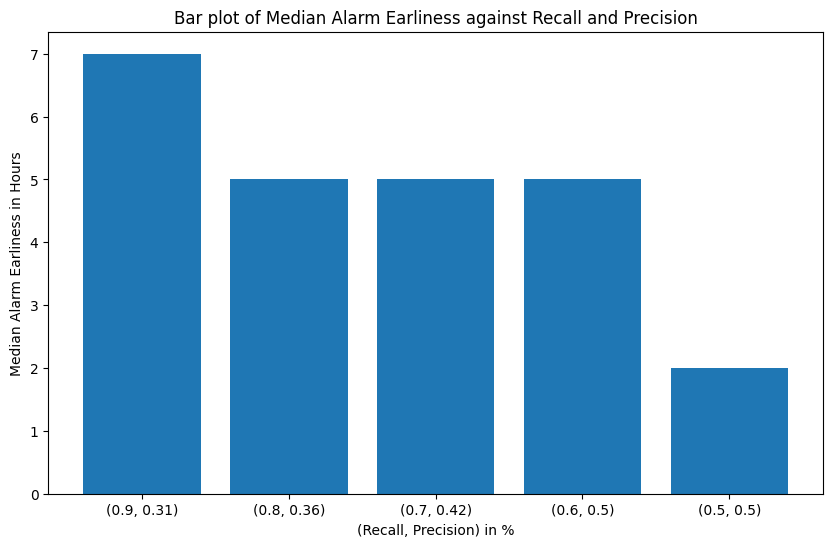

In [10]:
# Zip the two lists and convert them to string for plotting
x_values = list(map(str, zip(recalls_target, precisions_target)))

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x_values, median_to_plot)
plt.xlabel('(Recall, Precision) in %')
plt.ylabel('Median Alarm Earliness in Hours')
plt.title('Bar plot of Median Alarm Earliness against Recall and Precision')
plt.show()

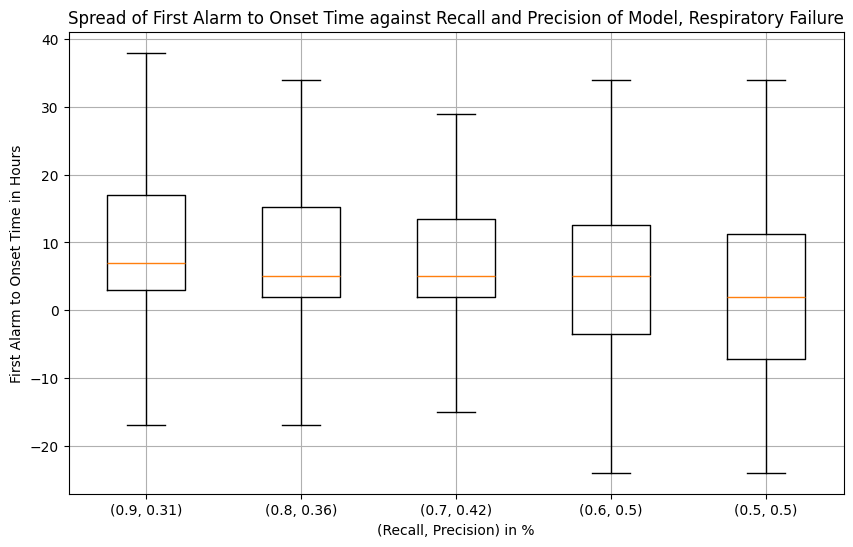

In [11]:
# Create the box plot
x_values = list(map(str, zip(recalls_target, precisions_target)))
plt.figure(figsize=(10, 6))
plt.boxplot(median_onset, showfliers=False)
plt.xticks(range(1, len(x_values) + 1), x_values)
plt.xlabel('(Recall, Precision) in %')
plt.ylabel('First Alarm to Onset Time in Hours')
plt.grid(True)

plt.grid(True, which='minor', linestyle=':', linewidth=0.5)

plt.title('Spread of First Alarm to Onset Time against Recall and Precision of Model, Respiratory Failure')
plt.show()

In [12]:

df_out = pd.DataFrame(columns=['patient_id', 'time_of_first_alarm', 'time_from_first_alarm_to_onset', 'time_to_onset_from_start'])
for i in range(len(final_patients)):
    patient_id = final_patients[i]
    out = predictions[i]
    target = targets[i]

    last_index = np.where(target == 100000.0)[0]
    if last_index.size != 0:
        last_index = last_index[0]
        target = target[:last_index]
        out = out[:last_index]
    else:
        last_index = 336

    out = (out > 0.5).astype(int)
    if np.sum(target == 1.0) > 0: # positive patient
        if np.sum(out) > 0: # predicted positive
            earliest_alarm = np.argmin(out == 1)
            time_from_first_alarm_to_onset = last_index - earliest_alarm
            time_of_first_alarm = earliest_alarm//12
            time_from_first_alarm_to_onset_hours = time_from_first_alarm_to_onset//12
            onset_time = last_index //12
        else:
            time_of_first_alarm = None
            time_from_first_alarm_to_onset_hours = None
            onset_time = last_index //12
    else: # negative patient
        if np.sum(out) > 0:
            earliest_alarm = np.argmax(out == 1)
            time_of_first_alarm = earliest_alarm//12
        else:
            time_of_first_alarm = None
        time_from_first_alarm_to_onset_hours = None
        onset_time = None

    new_row = {'patient_id': patient_id, 'time_of_first_alarm': time_of_first_alarm, 'time_from_first_alarm_to_onset': time_from_first_alarm_to_onset_hours, 'time_to_onset_from_start': onset_time}

    df_out.loc[i] = new_row
    
            

    

In [68]:
df_out

,patient_id,time_of_first_alarm,time_from_first_alarm_to_onset,time_to_onset_from_start
0,37349215,41,None,None
1,34002496,0,56,56
2,39349452,37,None,None
3,34702675,0,91,91
4,33342775,None,None,None
...,...,...,...,...
3369,35589504,None,None,51
3370,36451757,6,None,None
3371,31031876,0,28,28
3372,36450775,1,None,None


In [69]:
df_out.to_csv('respi_EWS_6_24_online.csv', index=False)
np.save('respi_EWS_6_24_raw_predictions.npy', predictions)

In [35]:
(predictions[1] > 0.5)

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [28]:
df_out.shape

(11624, 4)